### Jump to: <a id="contents"></a>

**Getting started**
- [import packages](#import)
- [intro to data](#intro)

**Data acquisition**
- [find articles by field](#articles)
- [find hyperlinks](#hyperlinks)
- [import prepared data](#prepared)

**Network**
- [build hyperlink network](#link_network)
- [build field-to-field network](#field_network)
- [calculate network features](#features)
- [degree distribution](#degree)

**Fields**
- [describe fields](#fields)
- [predict field with network features](#prediction)

-------------------------

### import packages <a id="import">

[**back**](#contents)

In [1]:
import wikipediaapi

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

import pickle
from tqdm.notebook import tqdm as tqdm
from itertools import combinations, repeat, chain, permutations

from functions import *

In [2]:
sns.set()

In [3]:
matplotlib.rcParams["figure.figsize"] = (15, 15)

-------------------------

### intro to data <a id="intro">

[**back**](#contents)

**DATA SOURCE**:

last time of data acquisition: March 12, 2021

[**Wikipedia hyperlinks**](https://snap.stanford.edu/data/wiki-topcats.html)

[**Wikipedia-API documentation**](https://pypi.org/project/Wikipedia-API/)

**ACADEMIC FIELDS**:

based on [**Wikipedia's list of academic field**](https://en.wikipedia.org/wiki/List_of_academic_fields)

------------

### find articles by field <a id="articles"></a>

[**back**](#contents)

In [3]:
fields = pd.concat(
    [
        pd.DataFrame(
            [
                [n.split("\n")[0], n.split("\n")[k]]
                for k in range(1, len(n.split("\n")))
            ],
            columns=["broad_field", "field"],
        )
        for n in open("fields.txt", "r").read().split("\n\n")
    ]
).reset_index(drop=True)

In [6]:
wiki = wikipediaapi.Wikipedia(
    language="en", extract_format=wikipediaapi.ExtractFormat.WIKI
)

In [ ]:
articles_dict = {
    category: find_category_members(wiki, category)
    for category in tqdm(fields["field"].unique())
}

In [15]:
articles = fields.merge(
    pd.concat(
        [
            pd.DataFrame([[key, v] for v in values], columns=["field", "article"])
            for key, values in articles_dict.items()
        ]
    ),
    on="field",
)

In [26]:
articles["article"].nunique()

39378

In [16]:
articles.head(5)

,broad_field,field,article
0,Humanities and social science,Anthropology,Ethnobiology
1,Humanities and social science,Anthropology,Complex society
2,Humanities and social science,Anthropology,Interindividual differences in perception
3,Humanities and social science,Anthropology,Téach
4,Humanities and social science,Anthropology,Political anthropology


In [19]:
articles.to_csv("output/articles.csv", index=False)

------------

### find hyperlinks <a id="hyperlinks"></a>

[**back**](#contents)

In [ ]:
edges_dict = {}

for n in tqdm(articles["article"].unique()):

    edges_dict[n] = set(articles["article"]).intersection(find_links(wiki, n))

In [23]:
all_edges = pd.DataFrame(
    np.concatenate(
        [
            np.array([[key, v] for v in values])
            for key, values in edges_dict.items()
            if len(values) != 0
        ]
    ),
    columns=["from", "to"],
).loc[lambda df: df["from"] != df["to"]]

In [24]:
all_edges.shape

(719413, 2)

In [28]:
all_edges.to_csv("output/all_edges.csv", index=False)

--------------

### build hyperlink network <a id="link_network"></a>

[**back**](#contents)

In [30]:
G_link = build_graph(articles["article"].unique(), all_edges.values, False, True,)

Name: 
Type: DiGraph
Number of nodes: 39378
Number of edges: 719413
Average in degree:  18.2694
Average out degree:  18.2694


In [31]:
L_link = G_link.subgraph(max(nx.strongly_connected_components(G_link), key=len))

In [32]:
print(nx.info(L_link))

Name: 
Type: DiGraph
Number of nodes: 24638
Number of edges: 655873
Average in degree:  26.6204
Average out degree:  26.6204


In [33]:
edges = (
    pd.DataFrame(list(L_link.edges()), columns=["from", "to"])
    .merge(
        articles.drop("broad_field", axis=1).rename(
            columns={"field": "field_from", "article": "from"}
        ),
        on="from",
        how="left",
    )
    .merge(
        articles.drop("broad_field", axis=1).rename(
            columns={"field": "field_to", "article": "to"}
        ),
        on="to",
        how="left",
    )
    .pipe(
        lambda df: df.merge(
            df.groupby(["from", "to"])["field_from"]
            .count()
            .pipe(lambda s: 1 / s)
            .reset_index()
            .rename(columns={"field_from": "weight"}),
            on=["from", "to"],
            how="left",
        )
    )
    .assign(within_field=lambda df: df["field_from"] == df["field_to"])
    .sort_values(by=["from", "to"])
    .reset_index(drop=True)
)

In [34]:
edges.head(5)

,from,to,field_from,field_to,weight,within_field
0,"""Holy...""",Catchphrase,Anthropology,Linguistics,0.5,False
1,"""Holy...""",Catchphrase,Cultural studies,Linguistics,0.5,False
2,'Ala' al-Din al-Bukhari,Akmal al-Din al-Babarti,Logic,Linguistics,1.0,False
3,'Ala' al-Din al-Bukhari,Astronomy in the medieval Islamic world,Logic,Astronomy,1.0,False
4,'Ala' al-Din al-Bukhari,Common Era,Logic,History,0.5,False


In [35]:
edges.to_csv("output/edges.csv", index=False)

-------------------

### build field-to-field network <a id="field_network"></a>

[**back**](#contents)

In [15]:
field_edges = (
    field_link_matrix.apply(lambda r: r / r.sum(), axis=1)
    .unstack()
    .reset_index()
    .rename(columns={"level_0": "from", "field_to": "to", 0: "weight"})
    .merge(
        fields[["field", "color"]],
        left_on="from",
        right_on="field",
    )
    .drop("field", axis=1)
)

In [16]:
G_field = build_graph(
    fields["field"].values,
    field_edges.drop("color", axis=1).values,
    True,
    True,
)

Name: 
Type: DiGraph
Number of nodes: 32
Number of edges: 1024
Average in degree:  32.0000
Average out degree:  32.0000


In [18]:
G_field_filtered = disparity_filter_alpha_cut(disparity_filter(G_field), alpha_t=0.2)

In [19]:
centers = {
    f: circle(100, (0, 0), 3)[n] for n, f in enumerate(fields["broad_field"].unique())
}

In [20]:
layout = (
    fields.loc[fields["field"].isin(G_field_filtered.nodes())]
    .groupby("broad_field")
    .apply(
        lambda df: df.sort_values(by="rel_size")[["field"]].assign(
            node_pos=circle(df.shape[0] * 3, centers[df.name], df.shape[0]),
            text_pos=circle(
                df.shape[0] * 3 + 15,
                (centers[df.name][0] - 10, centers[df.name][1]),
                df.shape[0],
            ),
        )
    )
    .set_index("field")[["node_pos", "text_pos"]]
    .T.to_dict()
)

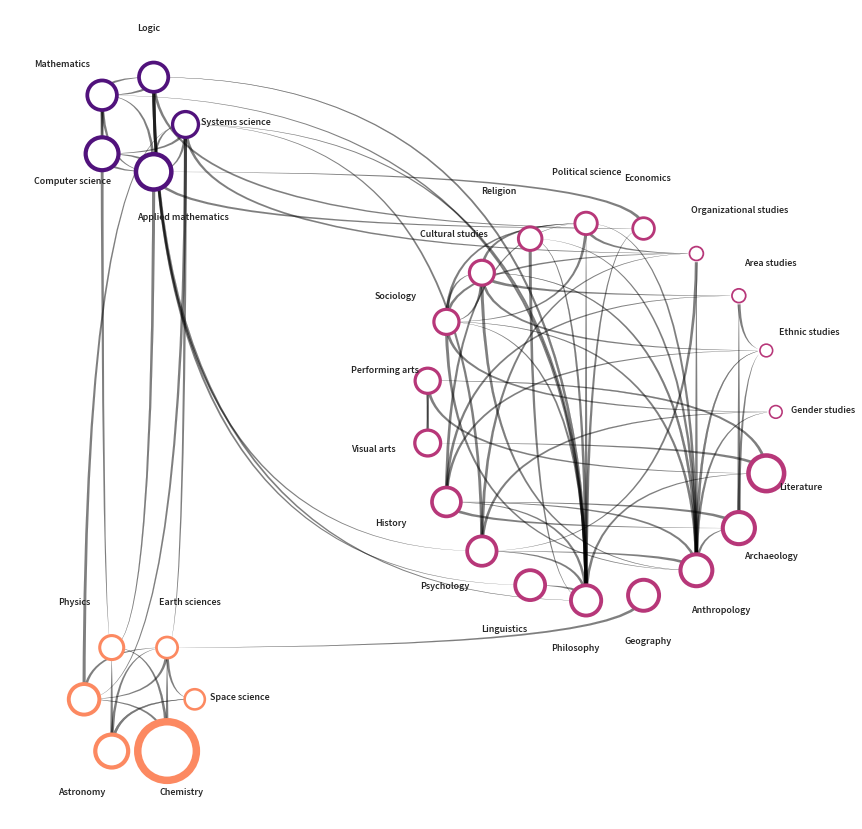

In [21]:
fig, ax = plt.subplots()
ax.axis("off")

nx.draw_networkx_nodes(
    G_field_filtered,
    {k: v["node_pos"] for k, v in layout.items()},
    node_size=[
        fields.loc[fields["field"] == n, "n_nodes_weighted"].values[0]
        for n in G_field_filtered.nodes
    ],
    node_color="white",
    edgecolors=[
        fields.loc[fields["field"] == n, "color_b"].values[0]
        for n in G_field_filtered.nodes
    ],
    linewidths=[
        fields.loc[fields["field"] == n, "rel_size"].values[0] ** 0.5 * 20
        for n in G_field_filtered.nodes
    ],
)

nx.draw_networkx_edges(
    G_field_filtered,
    {k: v["node_pos"] for k, v in layout.items()},
    width=[edge[2]["weight"] for edge in G_field_filtered.edges(data=True)],
    edge_color="black",
    arrowstyle="wedge",
    alpha=0.5,
    connectionstyle="angle3",
)

for f in fields["field"]:

    if f in layout.keys():

        ax.annotate(
            f,
            xy=layout[f]["text_pos"],
            font_properties=font_props["label"],
            fontsize=10,
        )

plt.show()

------------

### calculate network features <a id="features"></a>

[**back**](#contents)

In [39]:
nodes = (
    articles.drop("broad_field", axis=1)
    .loc[articles["article"].isin(set(L_link.nodes()))]
    .reset_index(drop=True)
    .rename(columns={"article": "node"})
    .pipe(
        lambda df: df.merge(
            df[["node"]]
            .drop_duplicates()
            .assign(
                in_degree=lambda df: df["node"].apply(lambda n: L_link.in_degree(n)),
                out_degree=lambda df: df["node"].apply(lambda n: L_link.out_degree(n)),
                neighbor_conn=lambda df: df["node"].apply(
                    neighbor_connectivity, args=(L_link, False, True)
                ),
                clustering=lambda df: df["node"].apply(clustering, graph=L_link),
            ),
            on="node",
        )
        .merge(
            df.merge(
                edges.loc[edges["within_field"]],
                left_on=["node", "field"],
                right_on=["to", "field_to"],
            )
            .drop(["to", "field_from", "field_to"], axis=1)
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "within_field_in_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["from", "field_from"])
            .drop(["from", "field_from", "field_to"], axis=1)
            .loc[lambda df: df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "within_field_out_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["to", "field_to"])
            .drop(["to", "field_from", "field_to"], axis=1)
            .loc[lambda df: ~df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "cross_field_in_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["from", "field_from"])
            .drop(["from", "field_from", "field_to"], axis=1)
            .loc[lambda df: ~df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "cross_field_out_degree"}),
            on=["node", "field"],
            how="left",
        )
        .fillna(0)
        .merge(
            pd.DataFrame.from_dict(
                {n: len(grow_canopy(n, L_link)) for n in df["node"].unique()},
                orient="index",
                columns=["canopy"],
            )
            .reset_index()
            .rename(columns={"index": "node"}),
            on="node",
        )
    )
    .merge(
        pd.DataFrame.from_dict(
            nx.betweenness_centrality(L_link),
            orient="index",
            columns=["betwenness"],
        )
        .merge(
            pd.DataFrame.from_dict(
                nx.closeness_centrality(L_link),
                orient="index",
                columns=["closeness"],
            ),
            left_index=True,
            right_index=True,
        )
        .merge(
            pd.DataFrame.from_dict(
                nx.closeness_centrality(L_link.reverse()),
                orient="index",
                columns=["closeness_out"],
            ),
            left_index=True,
            right_index=True,
        )
        .reset_index()
        .rename(columns={"index": "node"}),
        on="node",
        how="left",
    )
)

In [32]:
nodes.head(5)

,field,node,in_degree,out_degree,neighbor_conn,clustering,within_field_in_degree,within_field_out_degree,cross_field_in_degree,cross_field_out_degree,canopy,betwenness,closeness,closeness_out
0,Anthropology,Ethnobiology,98,143,237.460581,0.296779,22.058333,23.975000,26.941667,47.525000,15350,0.000609,0.306946,0.299629
1,Biology,Ethnobiology,98,143,237.460581,0.296779,0.500000,11.000000,48.500000,60.500000,15350,0.000609,0.306946,0.299629
2,Anthropology,Complex society,11,11,377.545455,0.164474,0.916667,1.250000,4.583333,4.250000,9723,0.000024,0.286141,0.266018
3,Archaeology,Complex society,11,11,377.545455,0.164474,0.500000,0.500000,5.000000,5.000000,9723,0.000024,0.286141,0.266018
4,Anthropology,Political anthropology,114,115,256.956332,0.496272,35.208333,35.291667,21.791667,22.208333,11526,0.000073,0.311766,0.276898


In [33]:
nodes.to_csv("output/nodes.csv", index=False)

-------------

### degree distribution <a id="degree"></a>

[**back**](#contents)

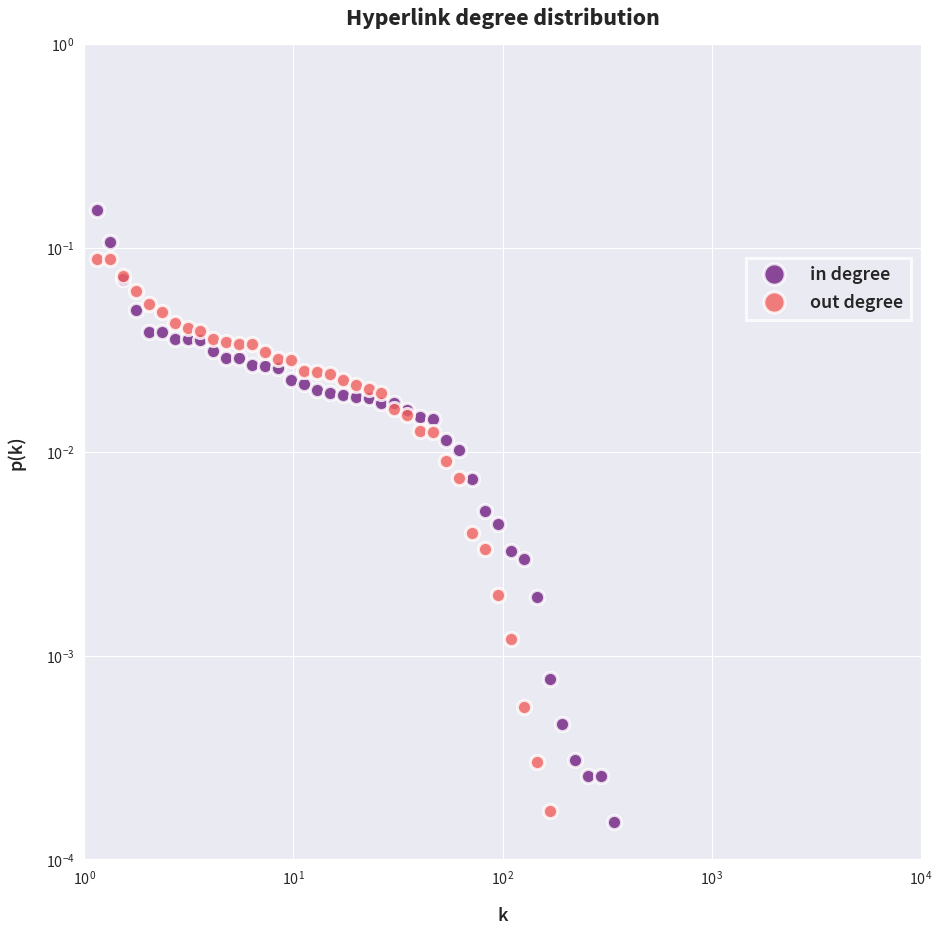

In [229]:
degree_dist(
    nodes.drop_duplicates("node")[["in_degree", "out_degree"]].values.T,
    "Hyperlink degree distribution",
    labels=["in degree", "out degree"],
)

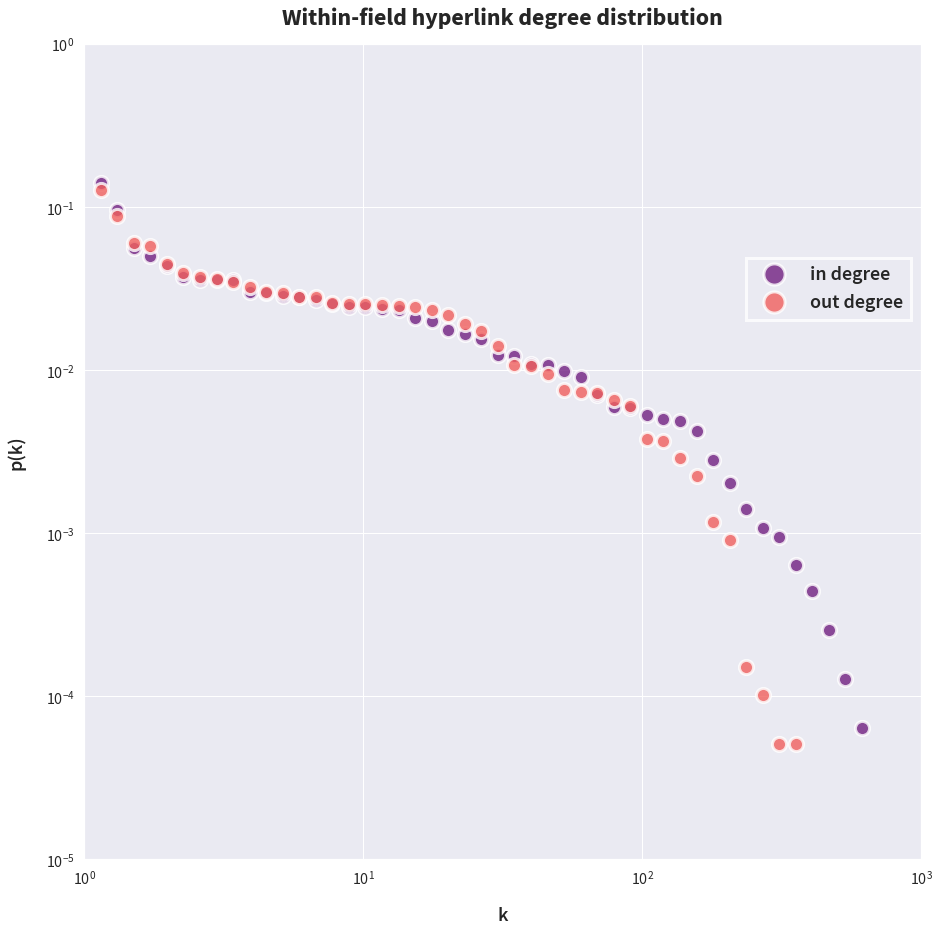

In [230]:
degree_dist(
    nodes.drop_duplicates("node")[
        ["within_field_in_degree", "within_field_out_degree"]
    ].values.T,
    "Within-field hyperlink degree distribution",
    labels=["in degree", "out degree"],
)

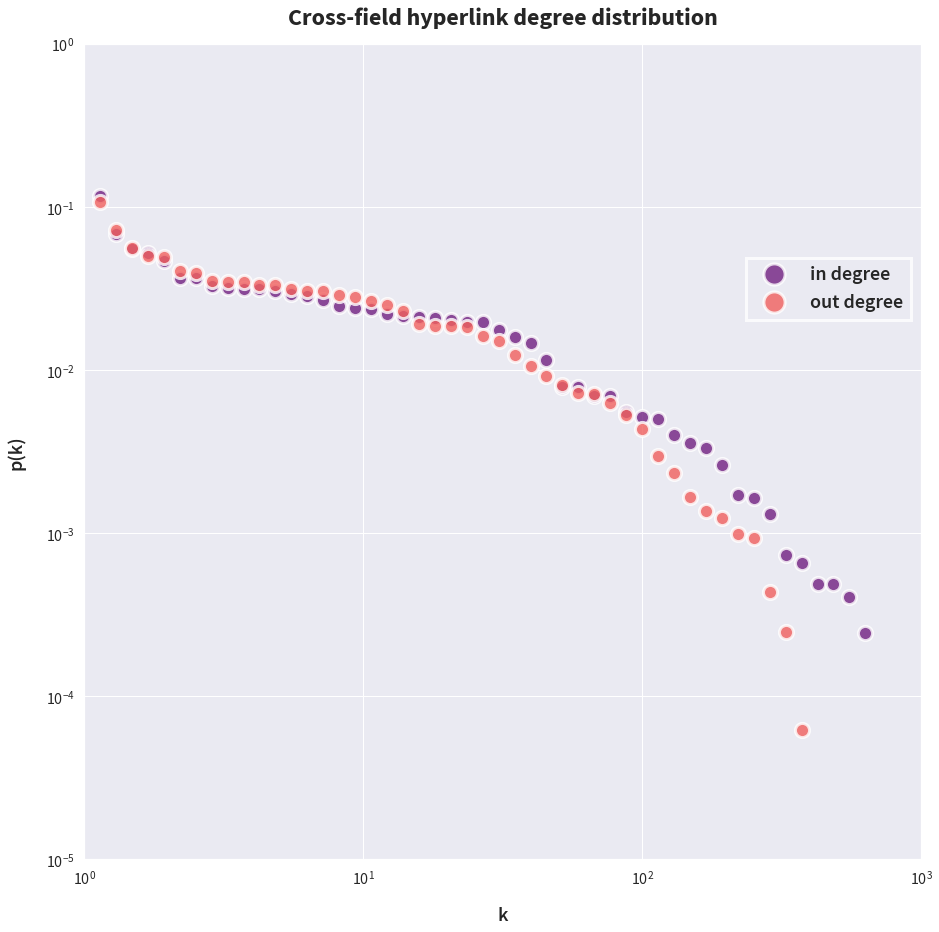

In [231]:
degree_dist(
    nodes.drop_duplicates("node")[
        ["cross_field_in_degree", "cross_field_out_degree"]
    ].values.T,
    "Cross-field hyperlink degree distribution",
    labels=["in degree", "out degree"],
)

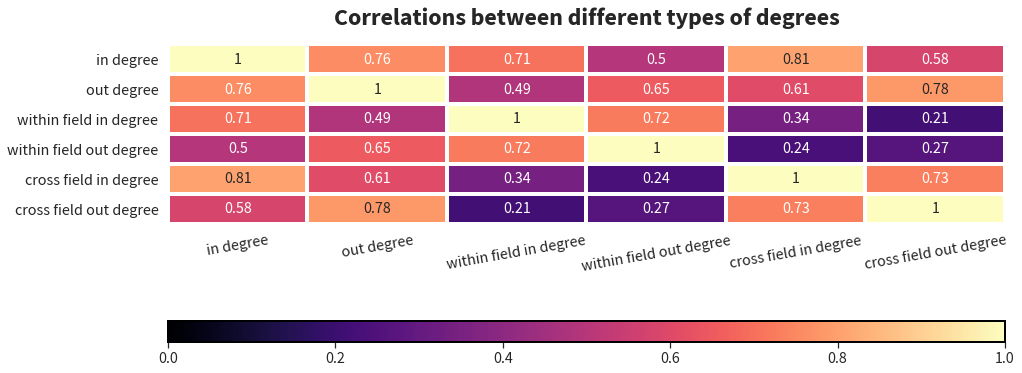

In [22]:
nodes[[c for c in nodes.columns if "degree" in c]].corr().abs().pipe(
    lambda df: corr_heatmap(
        df,
        "Correlations between different types of degrees",
        figsize=(15, 6),
        annot=df.round(2),
        xrotation=10,
        cbar_pad=0.3,
    )
)

-------------

### describe fields <a id="fields"></a>

[**back**](#contents)

In [118]:
field_link_matrix = edges[["field_from", "field_to", "weight"]].pivot_table(
    columns="field_from", index="field_to", values="weight", aggfunc="sum"
)

In [120]:
field_link_matrix.to_csv("output/field_link_matrix.csv")

In [77]:
fields = (
    (
        (
            fields.merge(
                nodes.groupby("field")["node"]
                .nunique()
                .reset_index()
                .rename(columns={"node": "n_nodes"}),
                on="field",
                how="right",
            )
            .merge(
                nodes.groupby("node")["field"]
                .nunique()
                .apply(lambda s: 1 / s)
                .reset_index()
                .rename(columns={"field": "n_nodes_weighted"})
                .merge(nodes[["node", "field"]], on="node", how="right")
                .groupby("field")["n_nodes_weighted"]
                .sum()
                .reset_index(),
                on="field",
                how="left",
            )
            .assign(
                rel_size=lambda df: df["n_nodes_weighted"].pipe(lambda s: s / s.sum())
            )
            .fillna(0)
        )
        .assign(
            ext_citations=lambda df: df["field"].apply(
                lambda f: (
                    field_link_matrix.loc[f, :].sum() - field_link_matrix.loc[f, f]
                )
            )
        )
        .pipe(
            lambda df: df.assign(
                rel_ext_use=lambda df: df["ext_citations"]
                / field_link_matrix.sum().sum()
                * (1 - df["rel_size"])
                / df["rel_size"],
                ext_cit_avg=lambda df: df["ext_citations"] / df["n_nodes_weighted"],
                imp_exp_ratio=lambda df: df["ext_citations"]
                / df["field"].apply(
                    lambda f: (field_link_matrix[f].sum() - field_link_matrix.loc[f, f])
                ),
            )
        )
    )
    .merge(
        field_link_matrix.sum(axis=1)
        .reset_index()
        .rename(
            columns={
                "field_to": "field",
                0: "in_degree",
            }
        ),
        on="field",
        how="left",
    )
    .merge(
        field_link_matrix.sum(axis=0)
        .reset_index()
        .rename(
            columns={
                "field_from": "field",
                0: "out_degree",
            }
        ),
        on="field",
        how="left",
    )
    .pipe(
        lambda df: df.assign(color=magma_as_hex(df.shape[0])),
        color_b=df["broad_field"].apply(
            lambda s: {
                f: magma_as_hex(df["broad_field"].nunique())[n]
                for n, f in enumerate(df["broad_field"].sort_values().unique())
            }[s]
        ),
    )
)

In [111]:
fields.head(5)

,broad_field,field,n_nodes,n_nodes_weighted,rel_size,ext_citations,rel_ext_use,ext_cit_avg,imp_exp_ratio,in_degree,out_degree,color,color_b
0,Humanities and social science,Anthropology,1262,1016.816667,0.041270,23390.508611,0.828474,23.003664,0.978002,38440.683333,38966.800000,#02020F,#B73779
1,Formal sciences,Applied mathematics,1432,1252.150000,0.050822,12820.809722,0.365084,10.239037,1.051382,21206.650000,20580.083333,#090720,#51127C
2,Humanities and social science,Archaeology,1112,1032.250000,0.041897,4971.222222,0.173331,4.815909,0.734513,19467.916667,21264.750000,#110C31,#B73779
3,Humanities and social science,Area studies,244,189.416667,0.007688,948.041667,0.186571,5.005059,0.666872,1237.500000,1711.083333,#1B1044,#B73779
4,Natural sciences,Astronomy,1147,1082.150000,0.043922,10443.177778,0.346597,9.650398,0.956892,46885.650000,47356.116667,#251155,#FC8961


In [112]:
fields.to_csv("output/fields.csv", index=False)

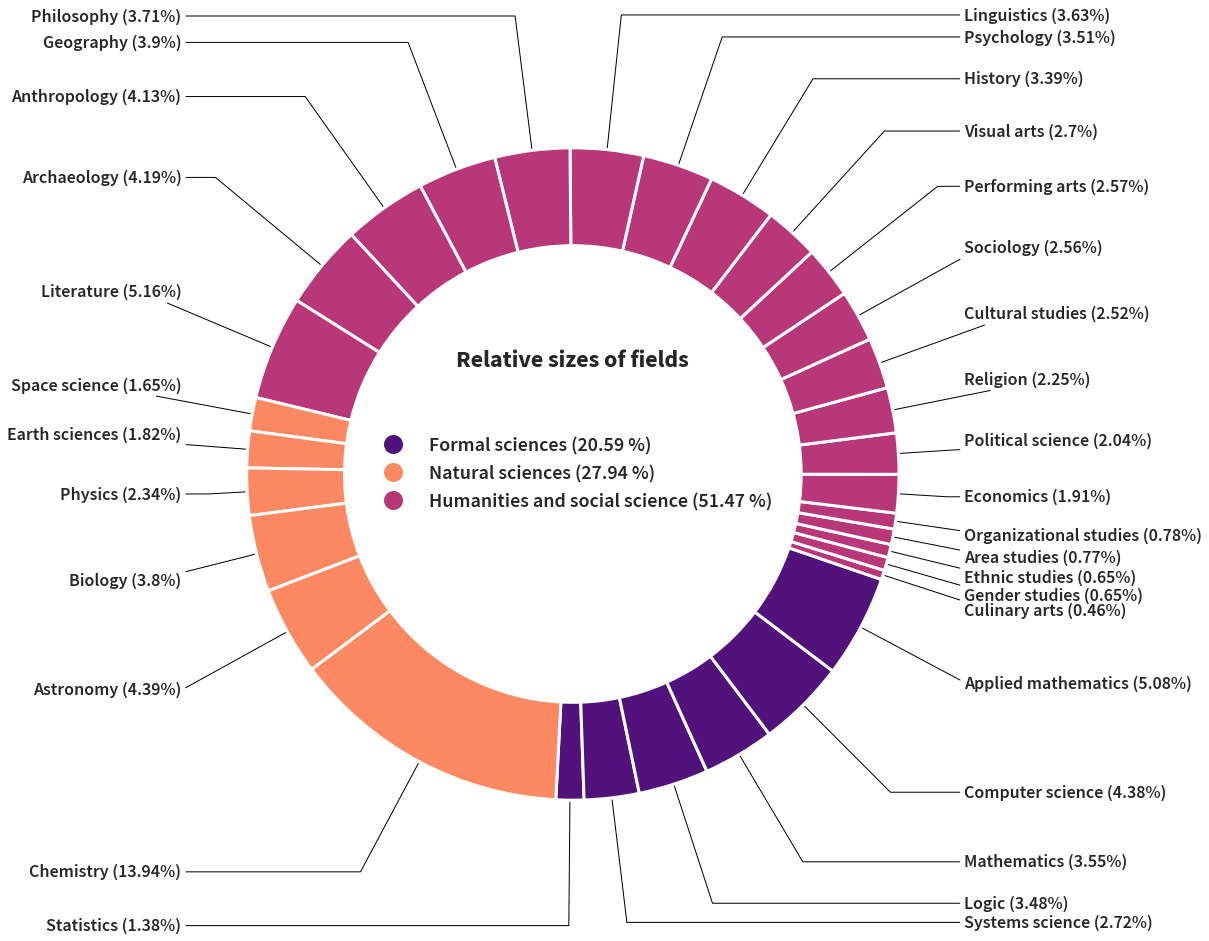

<Figure size 1080x1080 with 0 Axes>

In [23]:
sorted_fields = fields.sort_values(["broad_field", "rel_size"])
title = "Relative sizes of fields"

fig, ax = plt.subplots(figsize=(15, 15))

wedges, texts = ax.pie(
    sorted_fields["rel_size"].values,
    colors=sorted_fields["color_b"],
    wedgeprops={"width": 0.3, "linewidth": 3},
    startangle=-93,
)

for i, w in enumerate(wedges):

    ang = (w.theta2 - w.theta1) / 2.0 + w.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    ax.annotate(
        "{} ({}%)".format(
            sorted_fields["field"].values[i],
            round(100 * sorted_fields["rel_size"].values[i], 2),
        ),
        xy=(x, y),
        xytext=(1.2 * np.sign(x), 1.4 * y),
        horizontalalignment={-1: "right", 1: "left"}[int(np.sign(x))],
        font_properties=font_props["label"],
        fontsize=18,
        arrowprops={
            "color": "black",
            "arrowstyle": "-",
            "connectionstyle": f"angle,angleA=0,angleB={ang}",
        },
    )

plt.title(title, fontproperties=font_props["title"], pad=-300)

sorted_fields.groupby("broad_field")[["rel_size", "color_b"]].agg(
    {"rel_size": "sum", "color_b": "max"}
).sort_values(by="rel_size").pipe(
    lambda df: plt.legend(
        handles=[
            Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=20)
            for c in df["color_b"]
        ],
        labels=df.apply(
            lambda r: "{} ({} %)".format(r.name, round(r["rel_size"] * 100, 2)), axis=1
        ).values.tolist(),
        loc="center",
        prop=font_props["label"],
        frameon=False,
    )
)

plt.show()
plt.savefig(
    "figs/{}.png".format("_".join(title.lower().split(" "))), bbox_inches="tight"
)

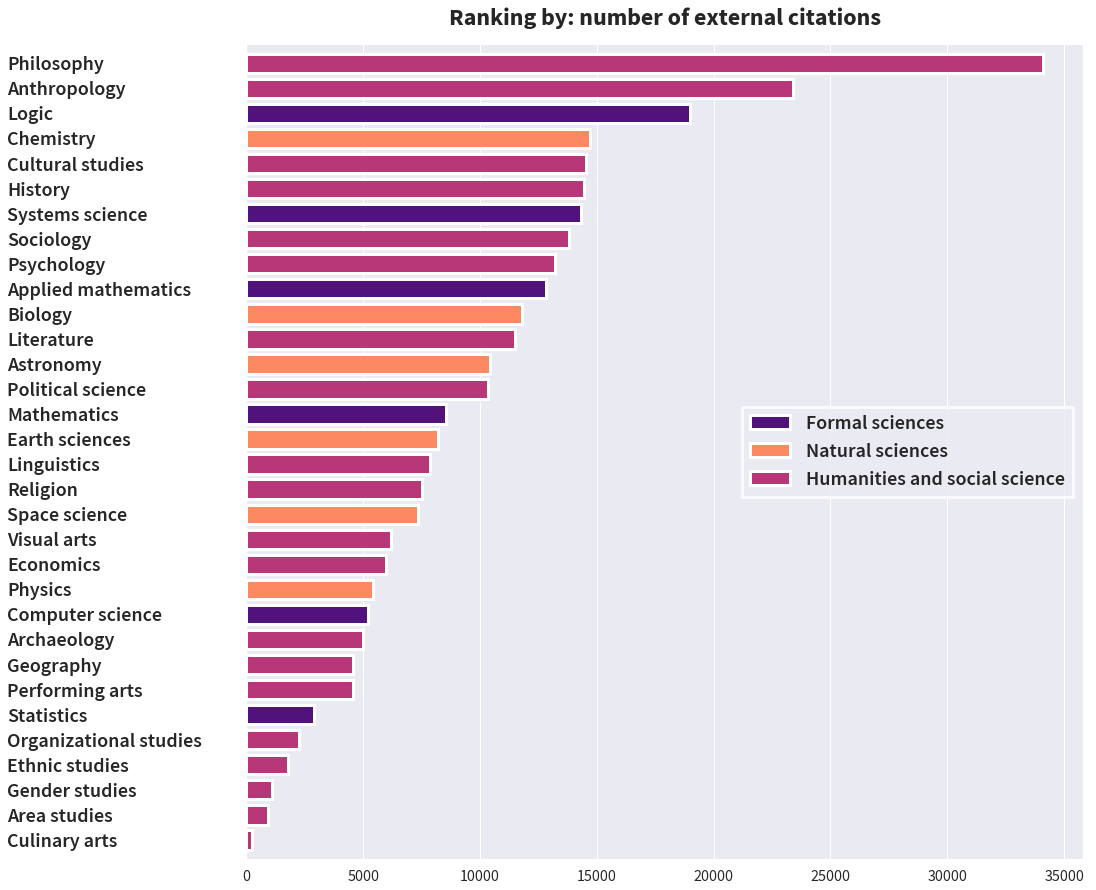

In [15]:
fields_bar_chart(fields, "ext_citations", "number of external citations", save=True)

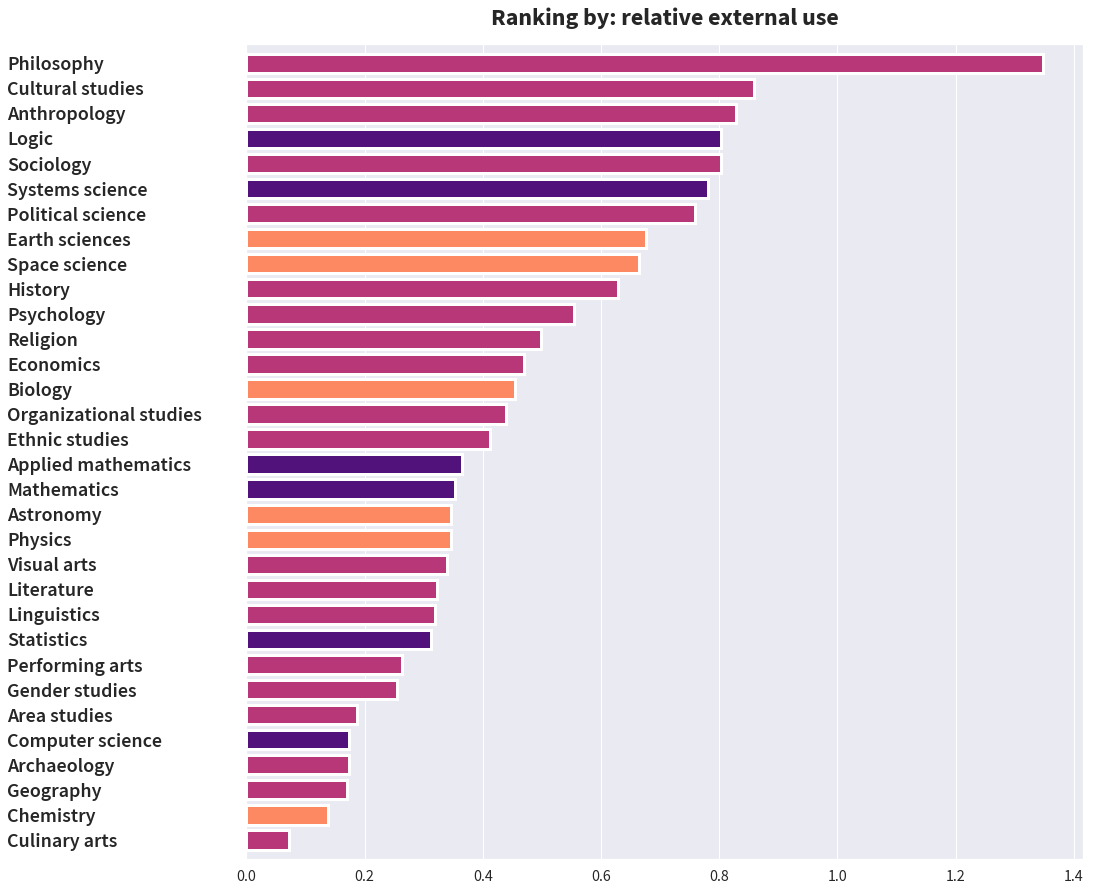

In [16]:
fields_bar_chart(
    fields, "rel_ext_use", "relative external use", add_legend=False, save=True
)

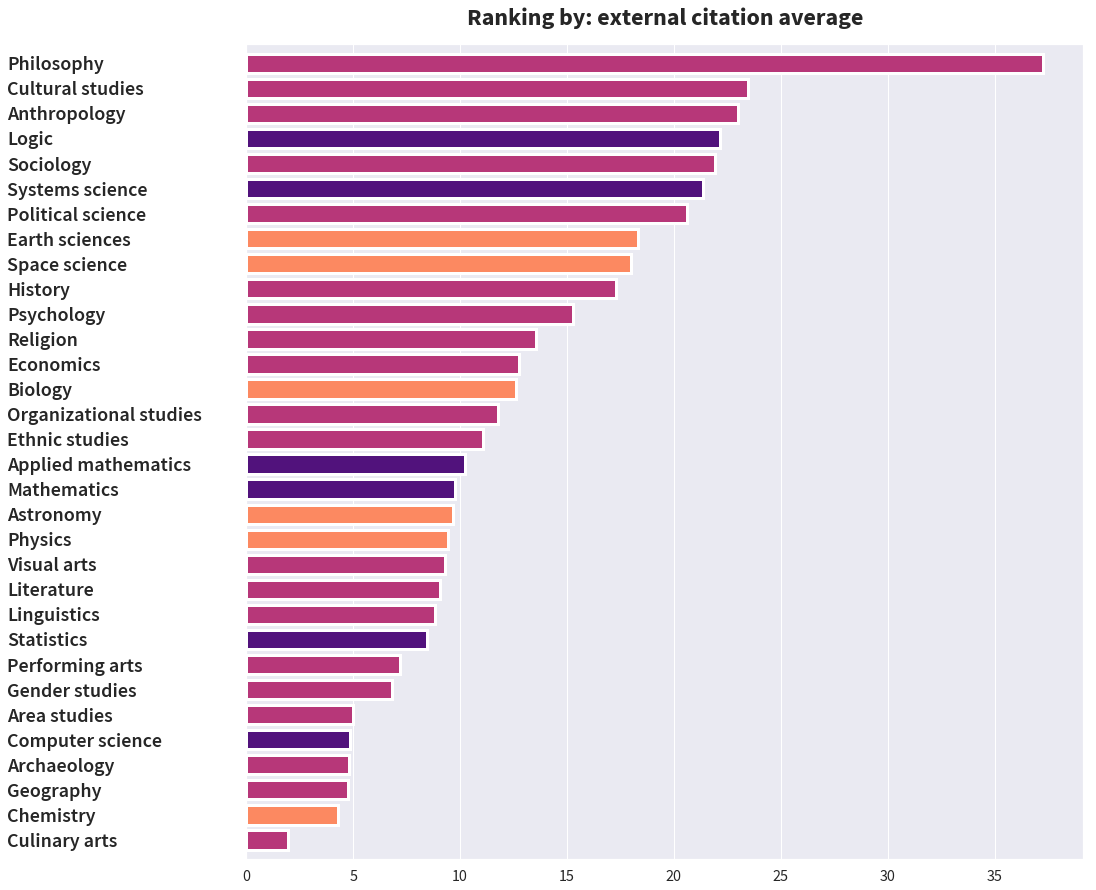

In [17]:
fields_bar_chart(
    fields, "ext_cit_avg", "external citation average", add_legend=False, save=True
)

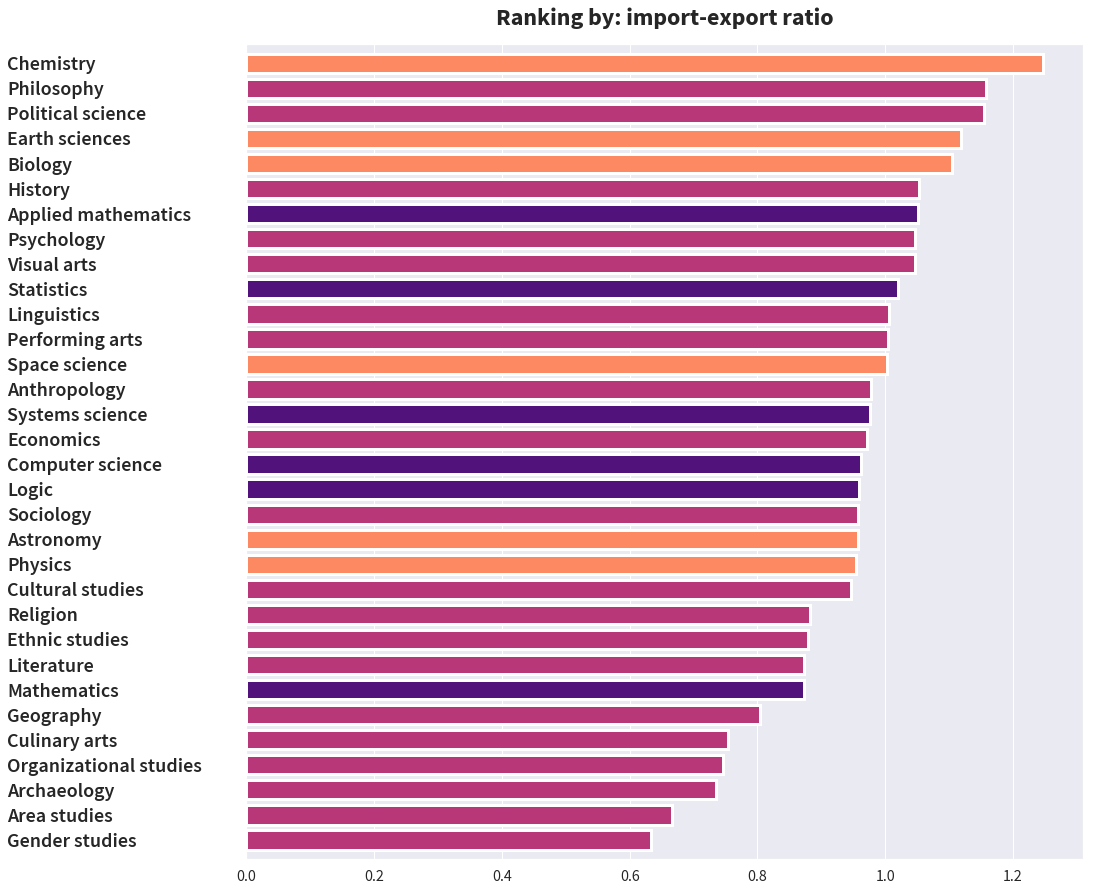

In [18]:
fields_bar_chart(
    fields, "imp_exp_ratio", "import-export ratio", add_legend=False, save=True
)

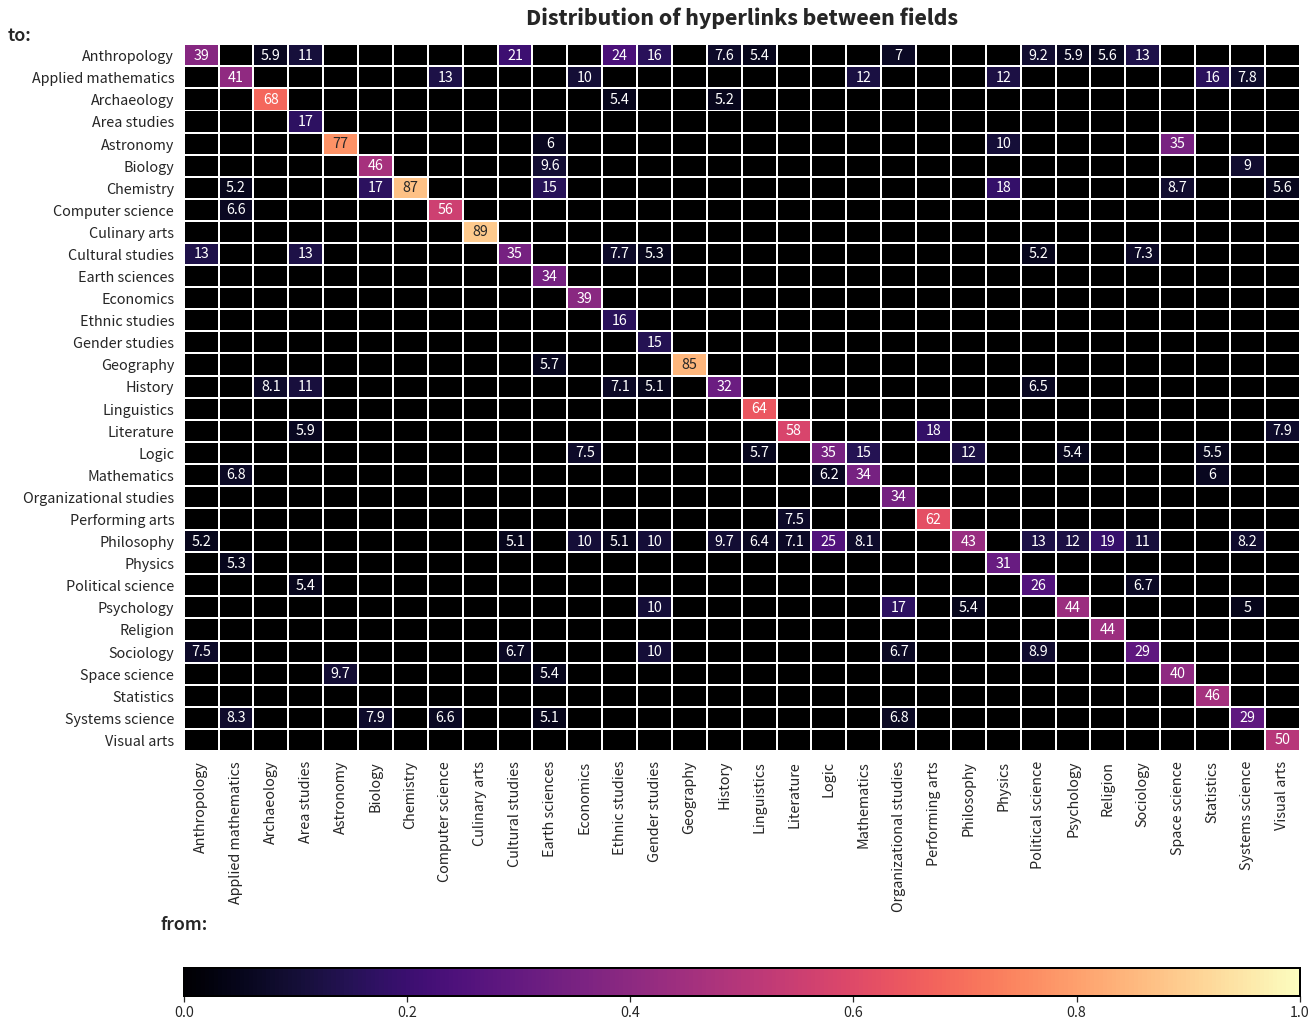

<Figure size 1080x1080 with 0 Axes>

In [36]:
field_link_matrix.div(field_link_matrix.sum(), axis=1).pipe(
    lambda df: corr_heatmap(
        df,
        "Distribution of hyperlinks between fields",
        figsize=(20, 20),
        annot=(df * 100).round(2),
        mask=df < 0.05,
        xlabel="from:",
        ylabel="to:",
        cbar_pad=0.2,
        save=True
    )
)

----------

### predict field with network features <a id="prediction">

[**back**](#contents)

In [90]:
field_dummies = nodes.pivot_table(
    index="node", columns="field", values="in_degree", aggfunc="count"
).fillna(0)

In [91]:
field_dummies.to_csv("output/field_dummies.csv")

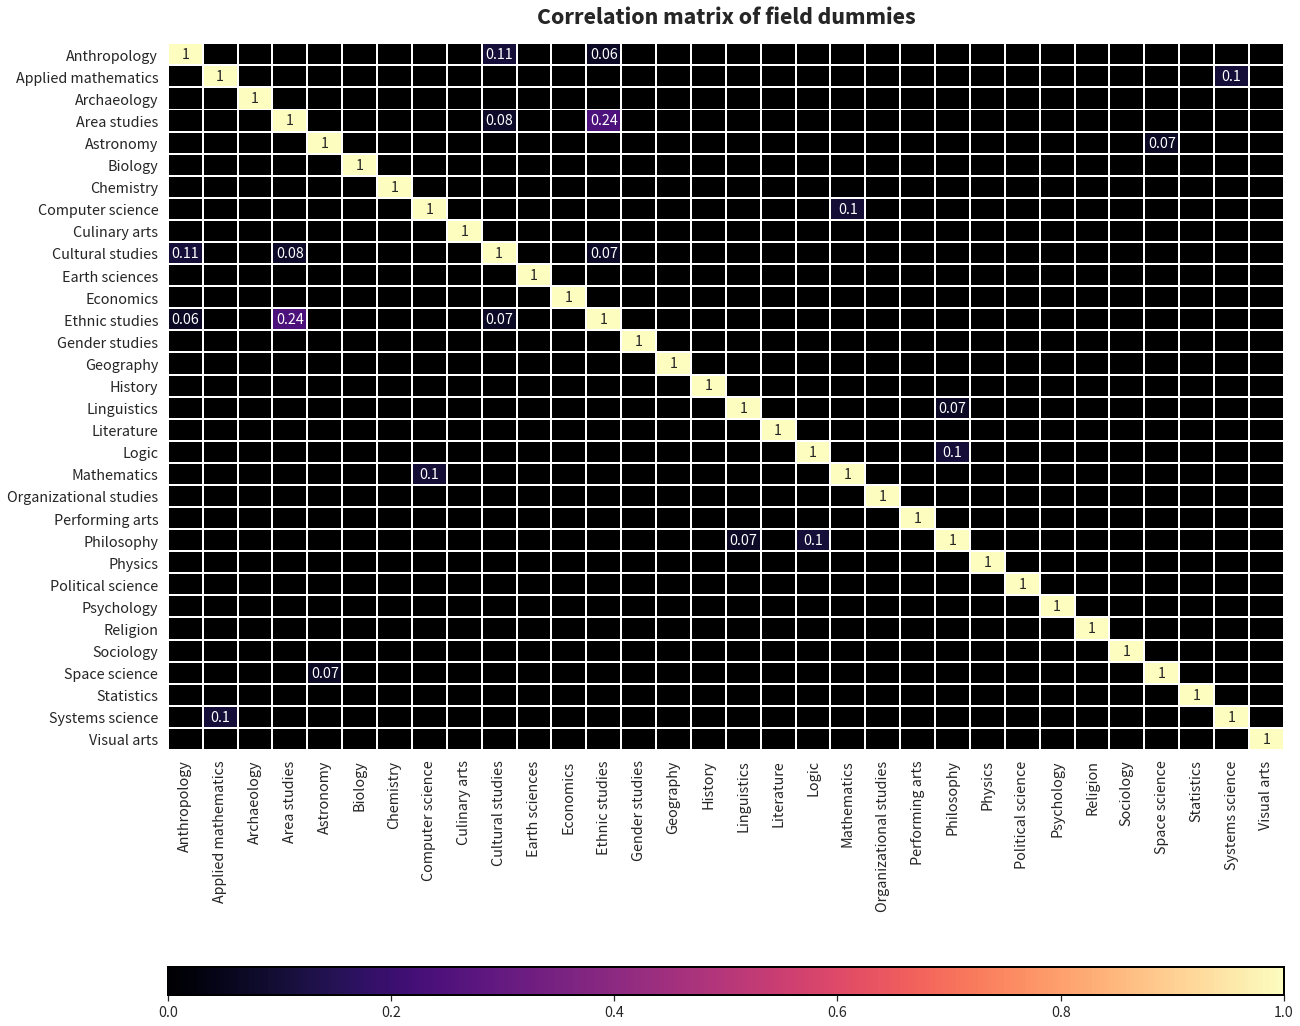

In [20]:
field_dummies.corr().pipe(
    lambda df: corr_heatmap(
        df,
        "Correlation matrix of field dummies",
        figsize=(20, 20),
        annot=df.round(2),
        mask=df < 0.05,
        cbar_pad=0.2,
    )
)

In [15]:
X = (
    (
        nodes.drop_duplicates(["node", "field"])
        .groupby("node")
        .mean()
        .assign(
            p_cross_field_in=lambda df: df["cross_field_in_degree"] / df["in_degree"],
            p_cross_field_out=lambda df: df["cross_field_out_degree"]
            / df["out_degree"],
        )
        .fillna(0)
    )[
        [
            "out_degree",
            "neighbor_conn",
            "clustering",
            "betwenness",
            "closeness",
            "closeness_out",
            "p_cross_field_in",
            "p_cross_field_out",
        ]
    ]
    .pipe(
        lambda df: pd.DataFrame(
            StandardScaler().fit_transform(df), columns=df.columns, index=df.index
        )
    )
    .assign(const=1)
)

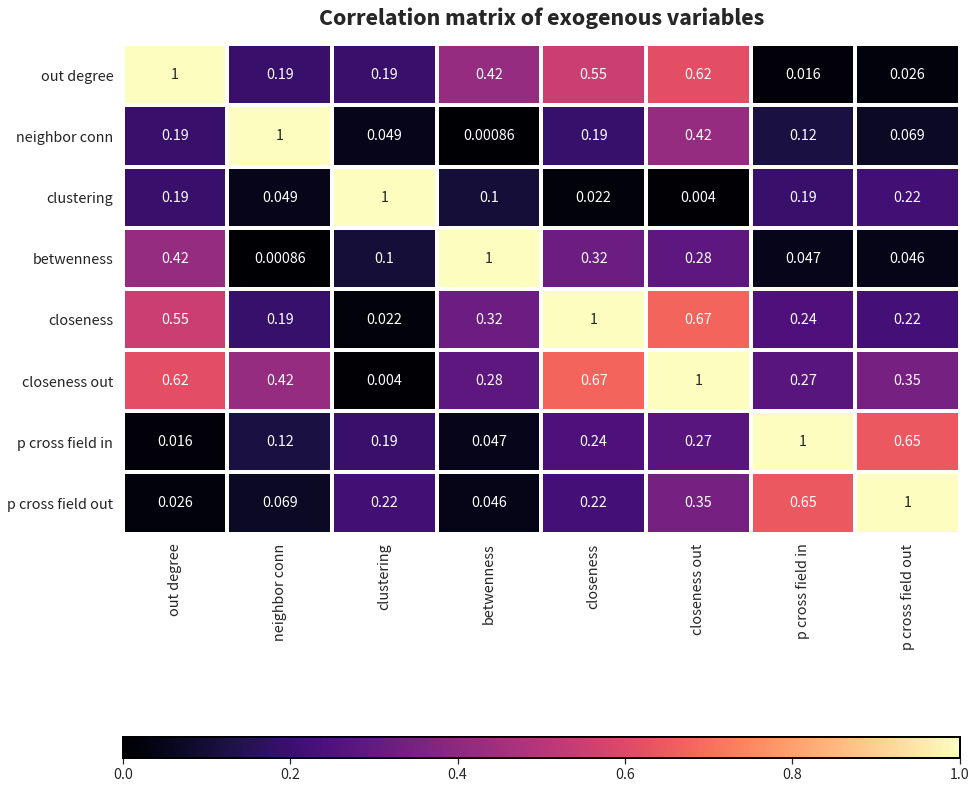

In [16]:
X.drop("const", axis=1).corr().abs().pipe(
    lambda df: corr_heatmap(
        df,
        "Correlation matrix of exogenous variables",
        annot=df,
    )
)

In [17]:
all_results = {
    f: logit_model(
        X,
        field_dummies[f],
    )
    for f in field_dummies.columns
}

In [18]:
field_coeff_matrix = (
    (
        pd.concat(
            [
                pd.DataFrame(
                    [
                        series.rename(index={i: c for i, c in enumerate(X.columns)})
                        for series in [
                            pd.Series(v["model"].p_values).rename("p"),
                            pd.Series(v["model"].coef_[0]).rename("coeffs"),
                        ]
                    ]
                ).T.assign(field=k)
                for k, v in all_results.items()
            ]
        )
        .drop("const")
        .assign(
            sign_coeffs=lambda df: (
                df["coeffs"] * (0.01 > df["p"]).astype(int)
            ).replace(0, np.nan)
        )
    )
    .reset_index()
    .rename(columns={"index": "var"})
    .pivot_table(index="field", columns="var", values="sign_coeffs", aggfunc="max")
)

In [19]:
reg_metrics = {k: v["metrics"] for k, v in all_results.items()}

In [20]:
field_coeff_matrix.to_csv("output/field_coeff_matrix.csv")

In [21]:
with open("output/reg_metrics.pickle", "wb") as fp:
    pickle.dump(reg_metrics, fp)

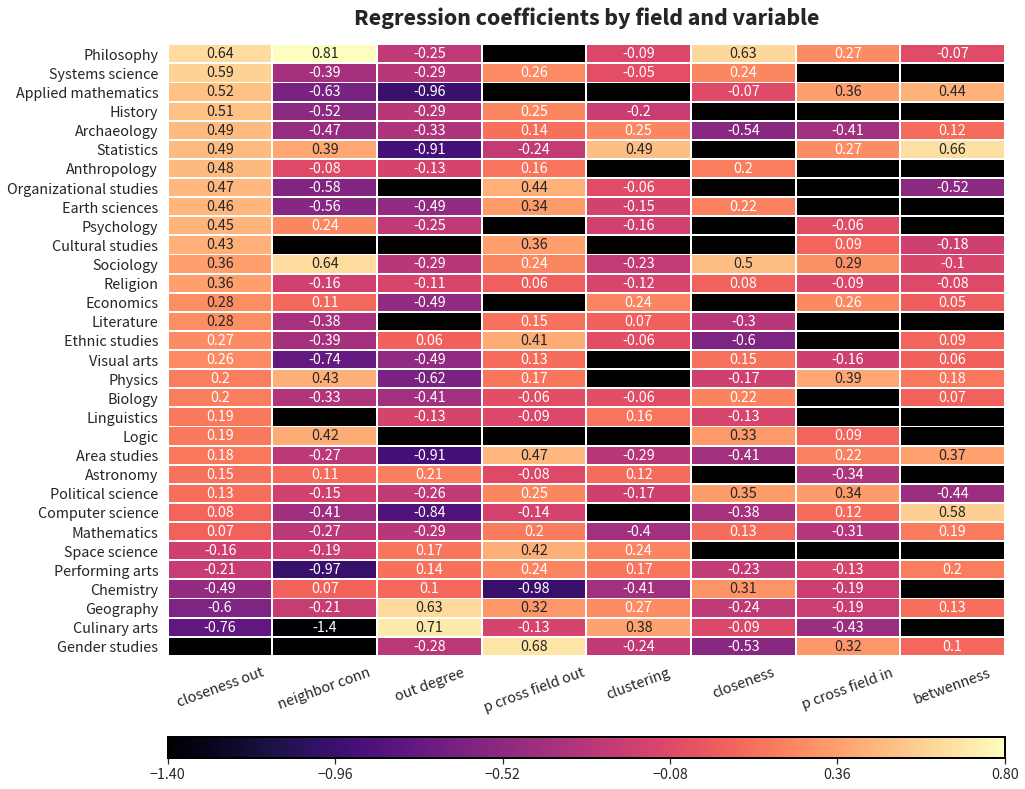

<Figure size 1080x1080 with 0 Axes>

In [22]:
field_coeff_matrix[field_coeff_matrix.isna().sum().sort_values().index.tolist()].pipe(
    lambda df: df.sort_values(by=df.columns.tolist(), ascending=False)
).pipe(
    lambda df: corr_heatmap(
        df,
        "Regression coefficients by field and variable",
        annot=df.round(2),
        vmin=df.round(1).min().min(),
        vmax=df.round(1).max().max(),
        mask=df.isna(),
        xrotation=20,
        cbar_nticks=6,
        cbar_pad=0.1,
        save=True
    )
)

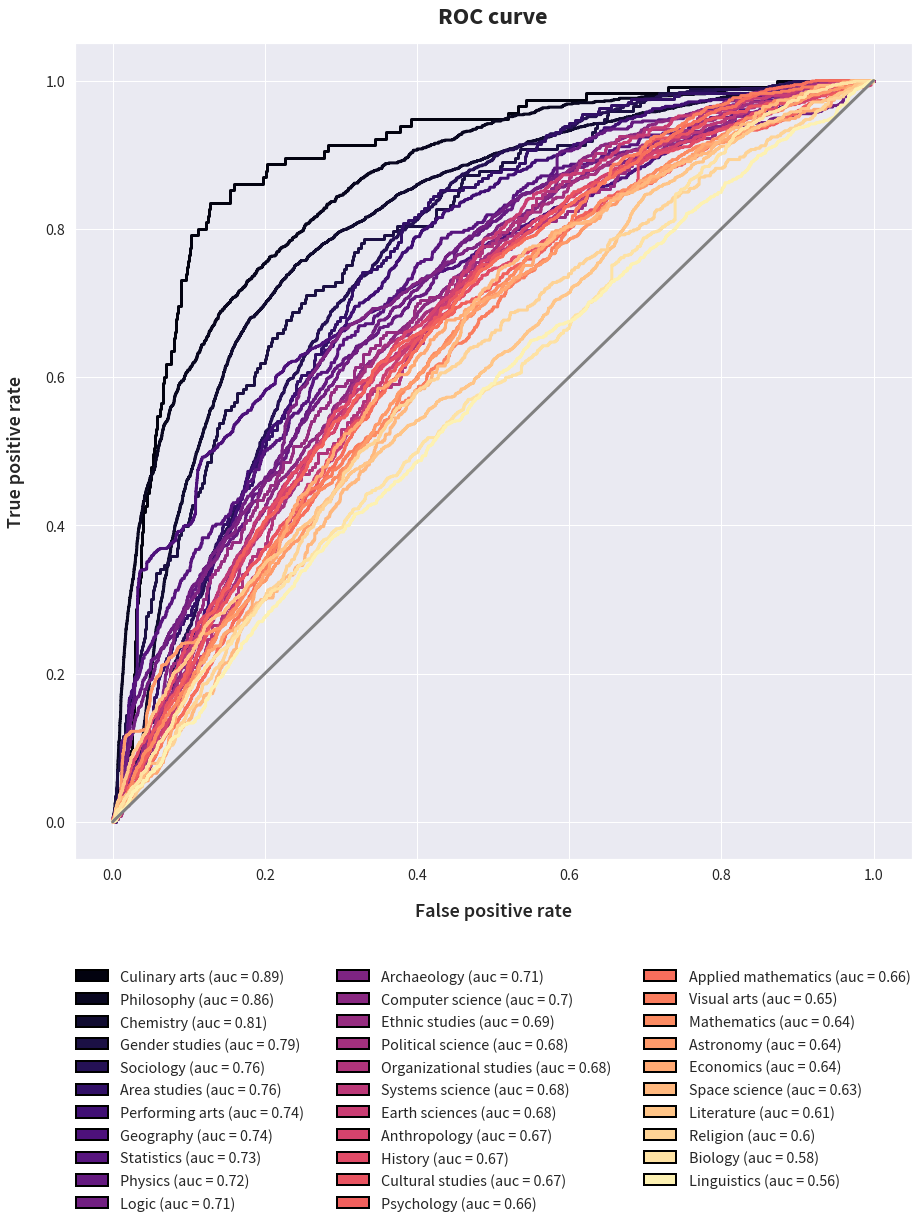

<Figure size 1080x1080 with 0 Axes>

In [24]:
plot_reg_metrics(
    reg_metrics, "False positive rate", "True positive rate", "ROC curve", save=True
)

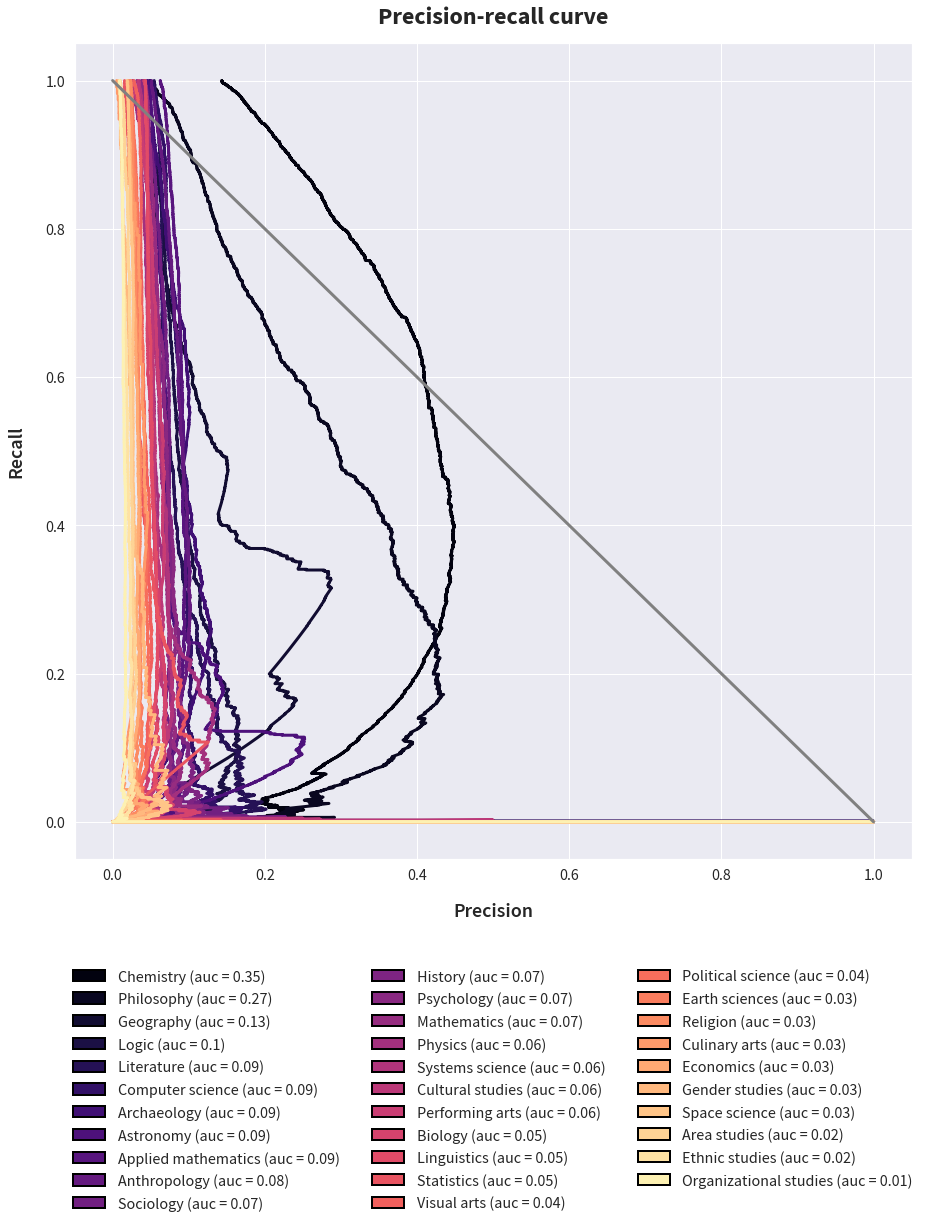

<Figure size 1080x1080 with 0 Axes>

In [25]:
plot_reg_metrics(
    reg_metrics,
    "Precision",
    "Recall",
    "Precision-recall curve",
    to_plot="p-r",
    save=True,
)

--------